# Algorytm Grovera

In [1]:
%matplotlib inline
# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.providers.ibmq import least_busy

# Loading your IBM Q account(s)
provider = IBMQ.load_account()

In [2]:
def sandwich(circuit, qbits, sandwiching, inside):
    for i in qbits:
        sandwiching(circuit, i)
    inside(circuit)
    for i in qbits:
        sandwiching(circuit, i)

## Rozwiązanie książkowe

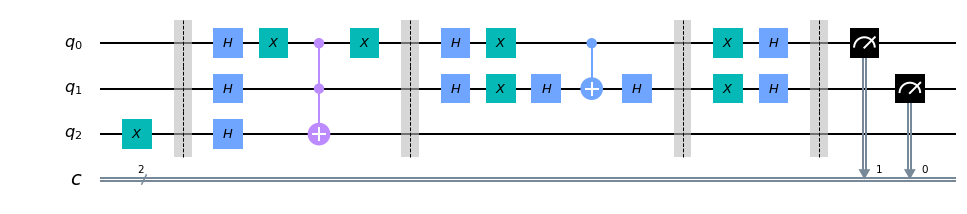

In [8]:
circ = QuantumCircuit(3, 2)
circ.x(2)
circ.barrier()
circ.h(0)
circ.h(1)
circ.h(2)
sandwich(circ, [0], lambda c, i: c.x(i), lambda c: c.toffoli(0,1,2))
circ.barrier()
circ.h(0)
circ.h(1)
circ.x(0)
circ.x(1)
circ.h(1)
circ.cx(0,1)
circ.h(1)
circ.barrier()
circ.x(0)
circ.x(1)
circ.h(0)
circ.h(1)
circ.barrier()
circ.measure([0,1], [1,0])
circ.draw()

Układ składa się z wyroczni oraz inwersji. Bramka X na qubicie 2 służy do ustalenia stanu początkowego na `|1>`. Wyrocznia znajduje się pomiędzy pierwszą a drugą barierą i wybiera stan `|01>` jako wyróżniony. Pomiędzy drugą a czwartą barierą znajduje się układ inwersji (3. bariera jest dla ładniejszego ułożenia bramek, wszystkie zostały usunięte przed wykonaniem eksperymentów). Sercem układu inwersji jest bramka controlled Z, stworzona z bramki cX obłożonej bramkami Hadamarda (zgodnie z tożsamością HXH = Z). Następnie bramka cZ jest obłożona bramkami X oraz bramkami Hadamarda. Inwersja zwiększa prawdopodobieństwo wystąpienia stanu wybranego, zmniejszając prawdopodobieństwa wystąpienia pozostałych stanów. Na końcu mierzymy otrzymany wynik.

Simulator {'01': 2048}
Experiment {'11': 177, '10': 62, '00': 128, '01': 657}


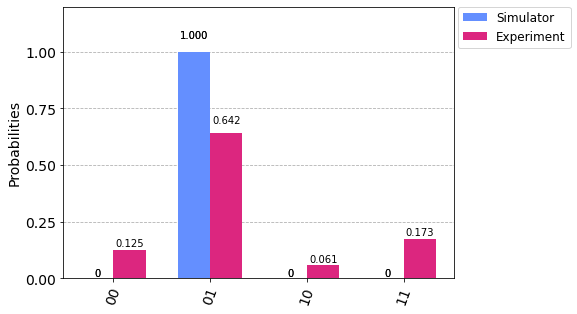

In [4]:
backend_sim = Aer.get_backend('qasm_simulator')
provider = IBMQ.get_provider(group='open')
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 3 and 
                                   not x.configuration().simulator and x.status().operational==True))

job_sim = execute(circ, backend_sim, shots=2048)
result_sim = job_sim.result()
counts = result_sim.get_counts(circ)
job_exp = execute(circ, backend=backend)
result_exp = job_exp.result()
counts_exp = result_exp.get_counts(circ)
print("Simulator", counts)
print("Experiment", counts_exp)
legend = ['Simulator', 'Experiment']
plot_histogram([counts, counts_exp], legend=legend)

Wynik otrzymany z symulatora jest dokładny, natomiast wynik z urządzenia jest jak zwykle obarczony błędem. Widzimy, że stan specjalny rzeczywiście został znaleziony. 

## Rozwiązanie z optymalizacjami

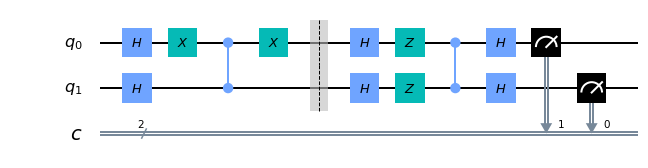

In [9]:
circ = QuantumCircuit(2, 2)
circ.h(0)
circ.h(1)
sandwich(circ, [0], lambda c, i: c.x(i), lambda c: c.cz(0,1))
circ.barrier()
circ.h(0)
circ.h(1)
circ.z(0)
circ.z(1)
circ.cz(0,1)
circ.h(0)
circ.h(1)
circ.measure([0,1], [1,0])
circ.draw()

Optymalizacja polega między innymi na usunięciu niepotrzebnego w zasadzie qubitu wyjściowego oraz zmniejszeniu ilości bramek. Możemy to osiągnąć zamieniając bramkę Toffoliego na bramkę controlled Z, która działa na dwóch qubitach. Również układ inwersji został zoptymalizowany. Wyrocznia znajduje się przed barierą. Za barierą znajduje się układ inwersji.

Simulator {'01': 2048}
Experiment {'11': 10, '10': 3, '00': 65, '01': 946}


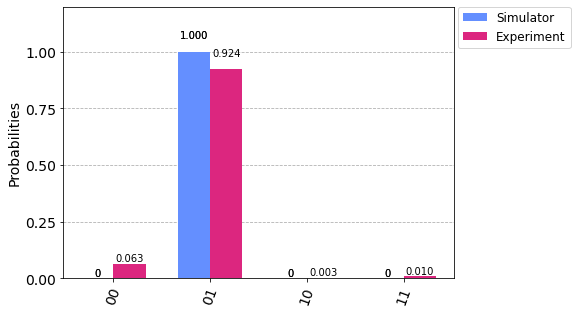

In [6]:
backend_sim = Aer.get_backend('qasm_simulator')
provider = IBMQ.get_provider(group='open')
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 3 and 
                                   not x.configuration().simulator and x.status().operational==True))

job_sim = execute(circ, backend_sim, shots=2048)
result_sim = job_sim.result()
counts_second = result_sim.get_counts(circ)
job_exp = execute(circ, backend=backend)
result_exp = job_exp.result()
counts_exp_second = result_exp.get_counts(circ)
print("Simulator", counts_second)
print("Experiment", counts_exp_second)
legend = ['Simulator', 'Experiment']
plot_histogram([counts_second, counts_exp_second], legend=legend)

Wynik z symulatora jest ponownie taki sam, wybiera on poprawny stan. Wynik z komputera kwantowego obarczony jest błędem

Simulator {'01': 2048}
Experiment {'11': 177, '10': 62, '00': 128, '01': 657}


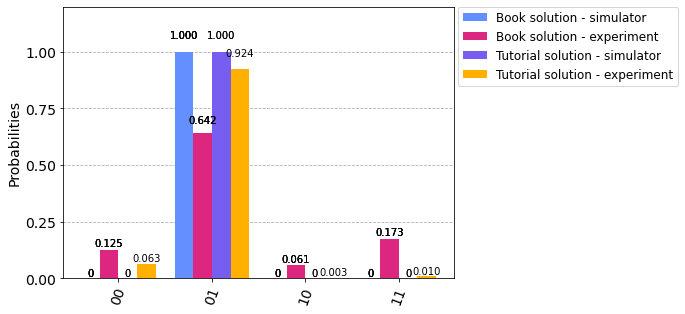

In [7]:
print("Simulator", counts)
print("Experiment", counts_exp)
legend = ['Book solution - simulator', 'Book solution - experiment', 'Tutorial solution - simulator', 'Tutorial solution - experiment']
plot_histogram([counts, counts_exp, counts_second, counts_exp_second], legend=legend)

Jak widzimy wyniki z komputera kwantowego po optymalizacji układu są zdecydowanie lepsze niż wyniki rozwiązania książkowego. Różnica ta wynika przede wszystkim z zastosowania mniejszej ilości qubitów oraz mniejszej ilości bramek, gdyż, jak wiemy, każda bramka wprowadza pewien błąd pomiarowy. 